In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

In [4]:
#####################################################
############### Code an MCMC sampler ################
#####################################################

# A Markov chain - is a way to model how a system changes 
# from one state to another given the current state.

# Monte Carlo - is the process of repeatably drawing samples 
# from a random system to numerically estimate the system.

# Marko Chain Monte Carlo - is the process of drawing samples 
# from a stateful system and then estimating the system from 
# its series of responses.

In [5]:
def sampler(samples=None,        # number of samples to trial
            init=None,           # the starting sample
            proposer=None,       # the function that suggests the next sample to trial
            weighter=None):      # the function that judges the fitness of the sample
    current = init
    markov_chain = [current]

    weight_current  = weighter(current)

    for i in range(samples):
        # propose new sample
        proposal = proposer(current)
                
        # compute the health of the new sample
        weight_proposal = weighter(proposal)
        
        # Acceptance ratio for this new sample
        #  -- this is the the core of the markov chain - proposals can be rejected..
        acceptance_ratio = weight_proposal / weight_current
        accept = np.random.rand() < acceptance_ratio
        
        if accept:
            # Update position if if was accepted
            current = proposal
            weight_current = weight_proposal

        # and add the selected same to the chain of samples
        markov_chain.append(current)
        
    return markov_chain

In [4]:
#####################################################
############# formulate for a coin toss #############
#####################################################

In [5]:
# coin toss setup

#  guess next data point
def coin_proposal(current):
    # well coins have 2 faces... randomly choose one..
    return np.random.randint(2)

def coin_weight(current):
    # a "biased" coin
    if current == 1:
        return 9.0
    return 1.0

In [6]:
coin_chain = sampler(samples  = 1000, 
                    init      = 1,
                    proposer = lambda x: coin_proposal(x),
                    weighter = lambda x: coin_weight(x))

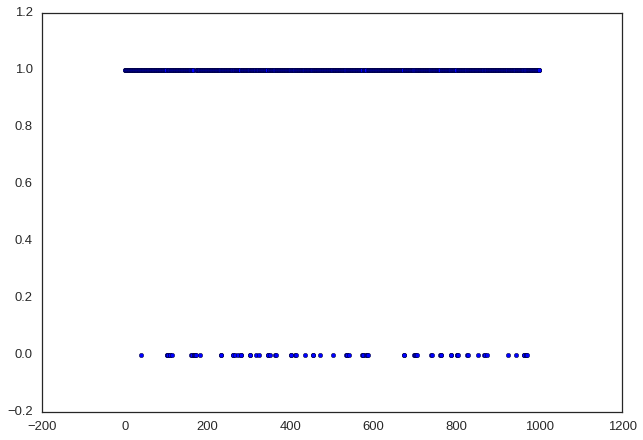

In [7]:
plt.scatter(range(len(coin_chain)), coin_chain)

<Container object of 10 artists>

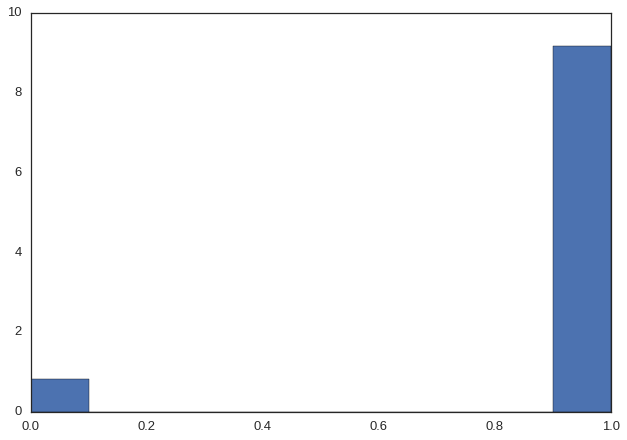

In [76]:
density, bins = np.histogram(coin_chain, bins=10, density=True)
plt.bar(bins[:-1],density,width=(bins[1]-bins[0]))

In [9]:
# the above looks odd.. but u need to realize this is a pdf 
# (not a probabilty mass function) so the *width* of the bin is critical
# the property of a pdf is that area sums to 1
print (bins[1]-bins[0])*density
print ((bins[1]-bins[0])*density).sum()

[ 0.08291708  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.91708292]
1.0


In [10]:
#####################################################
####### formulate for an unknown distrubution #######
#####################################################

Objective: We are given a set of samples $x$ and a model of the world we want to find the parameters $\theta$ that fit the model to the real world as best as possible. Ie we are looking for to find $max_\theta(P(\theta|x))$

In [6]:
#actual_mean = np.random.randn(1)
actual_mean = 1.08920342

In [7]:
# generate some "x" samples (with std dev 1 but with a random mean)
data = np.random.randn(100) + actual_mean

print actual_mean

1.08920342


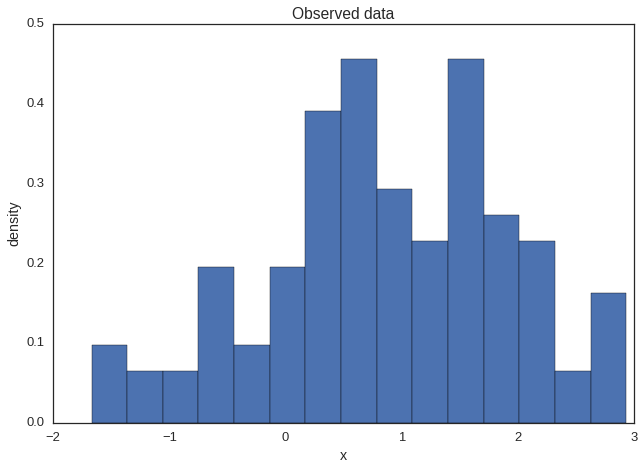

In [8]:
density, bins = np.histogram(data, bins=15, density=True)

ax = plt.subplot()
ax.bar(bins[:-1],density,width=(bins[1]-bins[0]))
ax.set(title='Observed data', 
       xlabel='x', 
       ylabel='density');

Define the model. 

\begin{equation}
P(x|\mu) := \text{Normal}(x; \mu, 1)
\end{equation}

Note that in bayesian analysis we treat all parameters($\theta$) as distrubutions.. in this model we only have one parameter however the mean $\mu$, we have assumed that the standard dev is set as 1. 

Now the objective is to find $max_\theta(P(\theta|x))$ so we need to reverse the model somehow. Hence enter the the bayes formula:

\begin{align}
P(\theta|x) = \frac{P(x|\theta) P(\theta)}{P(x)}
\end{align}

We also need to define the prior.. well we know we generated it from normal distrubution as well so lets cheat this time:

\begin{equation}
P(\mu) := \text{Normal}(0, 1)
\end{equation}


TODO - calculate the posterior i think its just the derivate of the maxium likelyhood function given the samples

In [9]:
# BUT! Given the above choices we can fit a model too this problem directly.. 
# the answer is 
def calc_posterior_analytical(data, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = 1.0 / (1. / sigma_0**2 + n / sigma**2)
    return mu_post, np.sqrt(sigma_post)

def draw_posterior_analytical(x, mu_post, sigma_post):
    return norm(mu_post, sigma_post).pdf(x)

analytic_mean, analytic_std = calc_posterior_analytical(data, 0., 1.)

print analytic_mean, analytic_std 

0.86965069228 0.099503719021


In [10]:
freq_mean = np.mean(data)
freq_var  = np.var(data)
print freq_mean, freq_var

0.878347199203 1.09369756849


In [11]:
x = np.linspace(-3, 3, 500)
posterior_analytical = draw_posterior_analytical(x, analytic_mean, analytic_std)

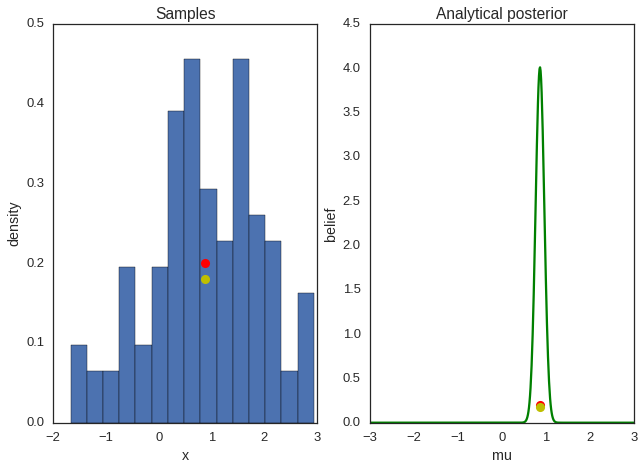

In [12]:
fig, ax = plt.subplots(1,2)

ax[0].bar(bins[:-1],density,width=(bins[1]-bins[0]))
ax[0].set(xlabel='x', ylabel='density', title='Samples');
ax[0].plot([analytic_mean], [0.2], marker='o', color="r")
ax[0].plot([freq_mean], [0.18], marker='o', color="y")
                     
ax[1].plot(x, posterior_analytical, color='g')
ax[1].set(xlabel='mu', ylabel='belief', title='Analytical posterior');
ax[1].plot([analytic_mean], [0.2], marker='o', color="r")
ax[1].plot([freq_mean], [0.18], marker='o', color="y")


But the point is to prove this using MCMC so we need to calculate some kind of weighting function for it based on the parameters $\theta$... We have have a function for $\theta$ from bayes therom.. 

\begin{equation}
P(\theta|x) = \frac{P(x|\theta) P(\theta)}{P(x)}
\end{equation}

Now we can also get $P(x|\theta)$ the "likelyhood" by assuming the samples are mutually exclusive:

\begin{align}
P(x|\theta) = \prod_i P(x_i|\theta)
\end{align}


In [13]:
def likelyhood(mu, data):
    # given the model configured with the mean of "mu", compute the probilities 
    # of each of the actual samples from "data"
    # And then assuming the samples are mutal excluive. We can simply multiply 
    # them all to find the overall chance of actually getting this set of samples 
    # from the this model    
    return norm(mu, 1).pdf(data).prod()

For the prior, well we cheated we know it was drawn from a normal.. 

\begin{align}
P(\theta) := \text{Normal}(0, 1)
\end{align}

In [14]:
# Compute prior: The probability that this "mu" was drawn from distrubution we used
def prior(mu): 
    return norm(0.0, 1.0).pdf(mu)

And for MCMC we dont need an actual posterior.. so we will simplify it remove constants(like $P(x)$) etc: 

\begin{align}
P(\theta|x) = \frac{P(x|\theta) P(\theta)}{P(x)}     \\
P(\theta|x) = \frac{P(x|\theta) P(\theta)}{C}        \\
P(\theta|x) \propto P(x|\theta) P(\theta)            \\
health(\theta) = P(x|\theta) P(\theta)
\end{align}

In [15]:
# the weighted "health" of the data point.. this determines if it is accepted for 
# the markov chain. 

# note very carefully the output of this function is a weighting for "theta" *NOT* the 
# actual posterior
def posterior_propto(current, data):
    return likelyhood(current, data) * prior(current)

In [16]:
# function to guess next data point
def draw_proposal(current, 
                  proposal_width=.5):
    # assume the current is the mean of a guassian.. and draw a sample from it
    return norm(current, proposal_width).rvs()

In [17]:
chain = sampler(samples  = 4000, 
                init     = -0.5,
                proposer = lambda x: draw_proposal(x),
                weighter = lambda x: posterior_propto(x,data))
                

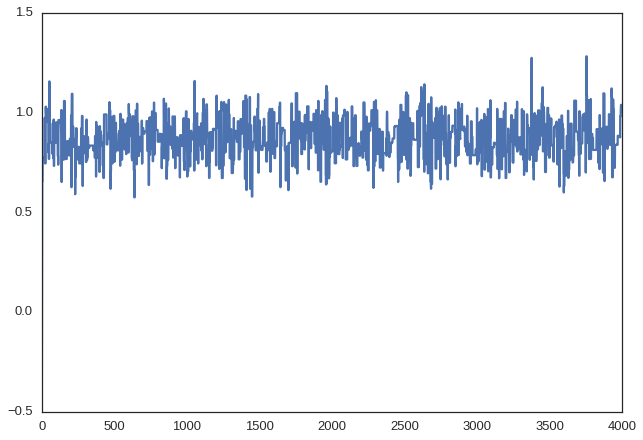

In [18]:
plt.plot(chain)

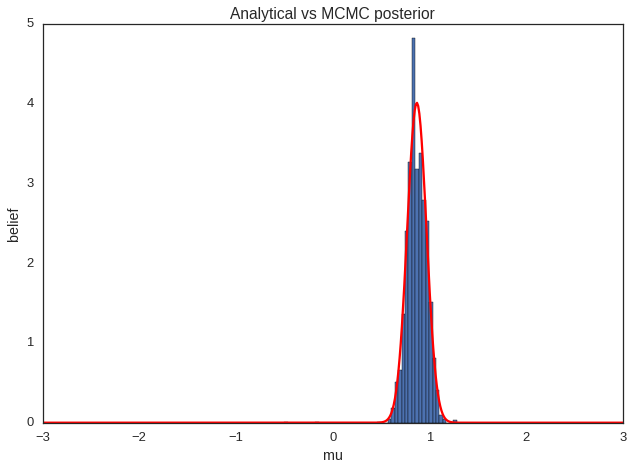

In [19]:
density, bins = np.histogram(chain, bins=50, density=True)

ax = plt.subplot()
ax.bar(bins[:-1],density,width=(bins[1]-bins[0]))
ax.plot(x, posterior_analytical, color='r')
ax.set(xlabel='mu', ylabel='belief', title='Analytical vs MCMC posterior');

In [24]:
#########################################################
############ reformulate for line regression ############
#########################################################

In [25]:
# generate the data

theta_true = (40, -1.5, 4)
size = 50
data = 100 * np.random.random((size,2))
data[:,1] = theta_true[0] + theta_true[1] * data[:,0]

# add scatter to points
data += theta_true[2]*np.random.randn(size,2)

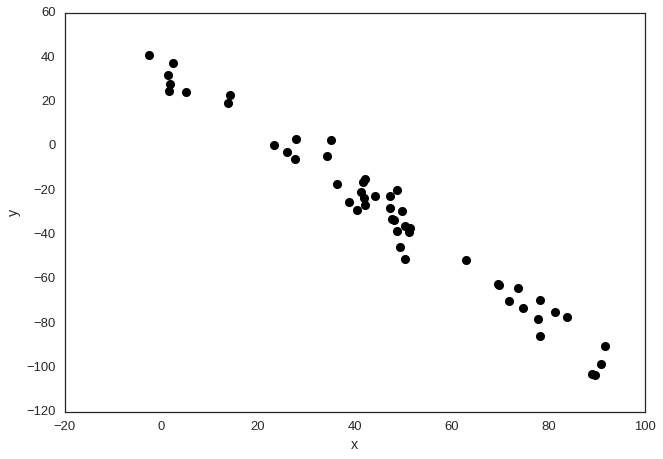

In [26]:
plt.plot(data[:,0], data[:,1], 'ok')
plt.xlabel('x')
plt.ylabel('y');

In [27]:
theta_test = []
theta_test.append(np.array(theta_true))
theta_test.append(theta_true*np.array([-1.0,-1.0,1.0]))
theta_test.append(theta_true*np.array([ 1.0, 1.0,0.0]))
theta_test.append(theta_true+np.array([1.0,0,0]))
theta_test.append(theta_true+np.array([0,1.0,0]))
theta_test.append(theta_true+np.array([0,0,1.0]))
theta_test.append(theta_true-np.array([1.0,0,0]))
theta_test.append(theta_true-np.array([0,1.0,0]))
theta_test.append(theta_true-np.array([0,0,1.0]))

theta_test.append(theta_true+np.array([0,0,100.0]))


theta_test.append(theta_true+0.01*np.random.randn(3))
theta_test.append(theta_true+0.01*np.random.randn(3))
theta_test.append(theta_true+0.01*np.random.randn(3))

theta_test = np.array(theta_test)

print theta_test

[[  40.           -1.5           4.        ]
 [ -40.            1.5           4.        ]
 [  40.           -1.5           0.        ]
 [  41.           -1.5           4.        ]
 [  40.           -0.5           4.        ]
 [  40.           -1.5           5.        ]
 [  39.           -1.5           4.        ]
 [  40.           -2.5           4.        ]
 [  40.           -1.5           3.        ]
 [  40.           -1.5         104.        ]
 [  40.01534065   -1.49186624    3.99370344]
 [  39.98422085   -1.50513094    4.00440677]
 [  40.01618896   -1.50033203    3.99767327]]


The objective is to fit a set of points $(x_i, y_i)$ with a linear line. So for linear regression(with some white noise) the model is:

\begin{equation} 
 y_i := \theta_0 + \theta_1 x_i + \epsilon  \\
 \epsilon :\sim \text{Normal}(0, \theta_2^2)   
\end{equation}

With this model we assume that the line fit is perfect but there is some error term $\epsilon$ causing any nosiy divergance in the sampled values... so the only uncertainity in this setup is the error term.. solve for it:

\begin{equation} 
 y_i := \theta_0 + \theta_1 x_i + \epsilon   \\
 \epsilon = y_i - \theta_0 - \theta_1 x_i   \\ 
\end{equation}

When we defined the model we also made the assumption that our error is normally distrubuted.. this it the common "white noise" assumption, and its rather good in practice because lots of process devolve into the guassian white noise. (refer to https://en.wikipedia.org/wiki/Central_limit_theorem)

\begin{equation} 
 \epsilon :\sim \text{Normal}(0, \theta_2^2)   \\
 P(\epsilon|\theta) = \frac{1}{\theta_2{\sqrt{2\pi}}} \exp\left[-\frac{\epsilon^2}{2\theta_2^2}\right]  \\
 P(x_i,y_i|\theta) = \frac{1}{\theta_2{\sqrt{2\pi}}} \exp\left[-\frac{(y_i - \theta_0 - \theta_1 x_i)^2}{2\theta_2^2}\right]
\end{equation}

Now we also assume that each sample $(x_i,y_i)$ is mutually exclusive from the next sample so that means $P(y,x|\theta)$ the "likelyhood" can be computed as follows:

\begin{align}
P(x,y|\theta) = \prod_i P(x_i,y_i|\theta)
\end{align}

This is helpful but not the solution.. Our target is to find the probability of the parameters and choose the best fit. So we are aiming to solve something like $max(P(\theta|y,x))$ which means we of course need to formulate $P(\theta|y,x)$.. ie the "posterior" which is distrubtion of the parameters given the data.. 

Since we have $P(x,y|\theta)$ We can now transform it using Bayes theorm:

\begin{align}
P(\theta|x.y) P(x,y) = P(x,y|\theta) P(\theta)     
\end{align}

And since we think its going to be unsolvable in an analytic way we will use a MCMC sampler to simulate the distrubition of the parameters. And since MCMC doesnt truely need the posterior.. just something propotional to it we can toss out any constants like $P(x,y)$ or $\frac{1}{\sqrt{2\pi}}$..   

\begin{align}
P(\theta|x,y) \propto P(x,y|\theta) P(\theta)   
\end{align}

SO all we have left to solve is the "prior" $P(\theta)$. So the question is what do we know about this? Answer.. Nothing. We are "uninformed" as the math lingo goes. So any answer is just as good as the next to us.. 

But there is a catch 22.. this isnt a dice or a coin where when we are "uniformed" we just assume its an even chance (50/50 on a coin, 1/6 on a dice etc). What we have 3 operational parameters, an intercept, a slope and a standard deviation.. each of these operates in a certain way...

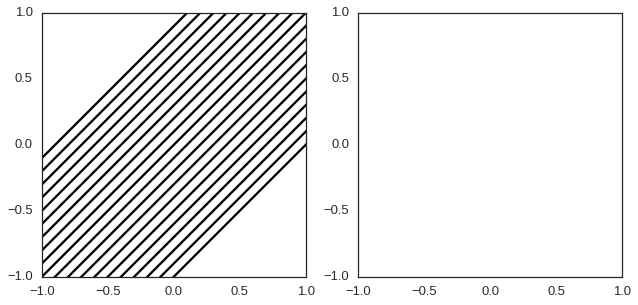

In [28]:
# for the intercept - not much funny here
fig, ax = plt.subplots(1,2, subplot_kw=dict(aspect='equal'))

for inter in np.arange(-1.0, 1.0, 0.1):
    ax[0].plot(x, x + inter, '-k')
    
ax[0].axis([-1, 1, -1, 1], aspect='equal');
ax[1].axis([-1, 1, -1, 1], aspect='equal');

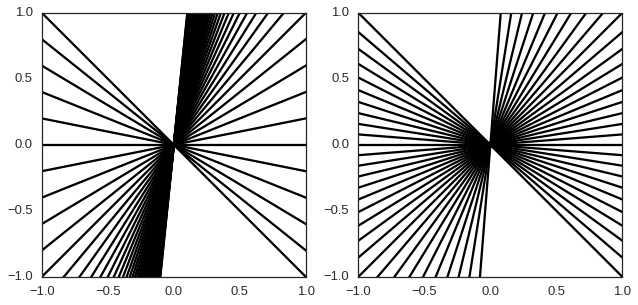

In [29]:
# for a slope - ahh yes this isnt good
fig, ax = plt.subplots(1,2, subplot_kw=dict(aspect='equal'))

for slope in np.arange(-1, 10, 0.2):
    ax[0].plot(x, slope * x, '-k')

#r = 1.0/np.arange(-1, 10, 0.2)
#for slope in r:
for slope in np.tan(np.arange(-np.pi/4, np.pi/2, np.pi/40)):
    ax[1].plot(x, slope * x, '-k')
    
ax[0].axis([-1, 1, -1, 1], aspect='equal');
ax[1].axis([-1, 1, -1, 1], aspect='equal');

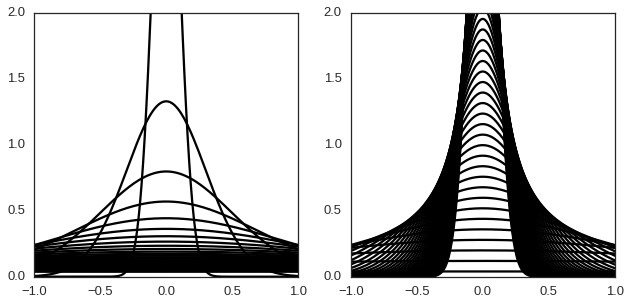

In [30]:
# for a std dev.. ouch
# https://en.wikipedia.org/wiki/Jeffreys_prior
# prefer precision over variance
fig, ax = plt.subplots(1,2, subplot_kw=dict(aspect='equal'))

for stddev in np.arange(0.1, 10, 0.2):
    ax[0].plot(x, norm(0, stddev).pdf(x), '-k')

for stddev in 1.0/np.arange(0.1, 10, 0.2):
    ax[1].plot(x, norm(0, stddev).pdf(x), '-k')
    
ax[0].axis([-1, 1, 0, 2], aspect='equal');
ax[1].axis([-1, 1, 0, 2], aspect='equal');

SO in conclusion we now know the following about the "uniformed" priors

\begin{equation}
P(\theta_0) \propto k  \\
P(\theta_1) \propto tan^{-1}(\theta_1) \\
P(\theta_2) \propto 1/ \theta_2 \\
\theta_2 > 0 
\end{equation}

And since each of these are mutually exclusive parameters we know the following:

\begin{equation}
P(\theta) \propto k * tan^{-1}(\theta_1) * 1/ \theta_2 
\end{equation}

And discard any constatns etc
\begin{equation}
P(\theta) \propto tan^{-1}(\theta_1) * 1/ \theta_2 
\end{equation}

And take the log
\begin{equation}
ln(P(\theta)) \propto ln(tan^{-1}(\theta_1)) - ln(\theta_2) 
\end{equation}


In [31]:
def line_log_prior(theta):
    if theta[2] < 0:
        return -np.inf # log(0)
    
    #return -np.log(theta[2])
    return np.log(np.pi/2 + np.arctan(theta[1]))  - np.log(theta[2])

In [32]:
for i in range(theta_test.shape[0]):
    print theta_test[i,:], "->", line_log_prior(theta_test[i,:])

[ 40.   -1.5   4. ] -> -1.91731826441
[-40.    1.5   4. ] -> -0.448794129297
[ 40.   -1.5   0. ] -> inf
[ 41.   -1.5   4. ] -> -1.91731826441
[ 40.   -0.5   4. ] -> -1.28450637333
[ 40.   -1.5   5. ] -> -2.14046181573
[ 39.   -1.5   4. ] -> -1.91731826441
[ 40.   -2.5   4. ] -> -2.35254670312
[ 40.   -1.5   3. ] -> -1.62963619196
[  40.    -1.5  104. ] -> -5.17541480243
[ 40.01534065  -1.49186624   3.99370344] -> -1.91147969155
[ 39.98422085  -1.50513094   4.00440677] -> -1.92110153803
[ 40.01618896  -1.50033203   3.99767327] -> -1.9169101464


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


\begin{equation} 
 P(x,y|\theta) = \prod_i \frac{1}{\theta_2{\sqrt{2\pi}}} \exp\left[-\frac{(y_i - \theta_0 - \theta_1 x_i)^2}{2\theta_2^2}\right] \\
 P(x,y|\theta) \propto \frac{1}{\theta_2^N} \prod_i \exp\left[-\frac{(y_i - \theta_0 - \theta_1 x_i)^2}{2\theta_2^2}\right] \\
 P(x,y|\theta) \propto \frac{1}{\theta_2^N} \exp^{\sum_i \left[-\frac{(y_i - \theta_0 - \theta_1 x_i)^2}{2\theta_2^2}\right]} \\
 P(x,y|\theta) \propto \frac{1}{\theta_2^N} \exp^{-\frac{1}{2\theta_2^2}\sum_i \left[(y_i - \theta_0 - \theta_1 x_i)^2\right]} \\
 ln(P(x,y|\theta)) \propto ln\left[\frac{1}{\theta_2^N} \exp^{-\frac{1}{2\theta_2^2}\sum_i \left[(y_i - \theta_0 - \theta_1 x_i)^2\right]}\right] \\
 ln(P(x,y|\theta)) \propto -Nln({\theta_2}) - {\frac{1}{2\theta_2^2}\sum_i \left[(y_i - \theta_0 - \theta_1 x_i)^2\right]}) \\
\end{equation}

In [33]:
def line_log_likelihood(theta, data):
    if theta[2] <= 0:
        return -np.inf # log(0)
    y_model = theta[0] + theta[1] * data[:,0]
    err = np.sum((data[:,1] - y_model)**2)    
    err =  err / (2 * theta[2]**2)
    sigma = -data.shape[0]*np.log(theta[2])
    res = sigma - err  
    return res

In [34]:
for i in range(theta_test.shape[0]):
    print theta_test[i,:], "->", line_log_likelihood(theta_test[i,:], data)

[ 40.   -1.5   4. ] -> -139.724468004
[-40.    1.5   4. ] -> -15167.3967288
[ 40.   -1.5   0. ] -> -inf
[ 41.   -1.5   4. ] -> -142.669318054
[ 40.   -0.5   4. ] -> -4605.87524877
[ 40.   -1.5   5. ] -> -125.534135589
[ 39.   -1.5   4. ] -> -139.904617954
[ 40.   -2.5   4. ] -> -4691.00107344
[ 40.   -1.5   3. ] -> -180.10350323
[  40.    -1.5  104. ] -> -232.323701392
[ 40.01534065  -1.49186624   3.99370344] -> -139.859891967
[ 39.98422085  -1.50513094   4.00440677] -> -139.951493713
[ 40.01618896  -1.50033203   3.99767327] -> -139.814028366



\begin{equation}
P(\theta|x,y) \propto P(x,y|\theta) P(\theta)       \\
ln(P(\theta|x,y)) \propto ln(P(x,y|\theta)) + ln(P(\theta))   
\end{equation}


In [35]:
def line_log_posterior(theta, data):
    #return line_log_likelihood(theta, data)
    return line_log_prior(theta) + line_log_likelihood(theta, data)

In [36]:
# a complication here.. the proposal algorithm is often a confusing and hidden 
# breaking point in MCMC systems, if done badly it can bias the results 
#
# when we map the chain output for this one pay close attention to the 
# "digital" effect this one has

def line_proposal(theta):
    # single item udpate
    idx = np.random.randint(theta.shape[0])
    ntheta = theta.copy()
    ntheta[idx] = theta[idx] + np.random.randn()
    if ntheta[2] < 0:
        ntheta[2] = -ntheta[2]
    return ntheta

In [37]:
# unfornatually as number of varables grow and the range of operation widens
# the likelyhood can bottom out.. and completely fubar the algorithm 
# 
# There are several ways to address this, first off log of the probability  
# massivily widens the range of opearation, its also reduces the overall computational
# costs by switching multiplications for summations etc

In [38]:
def log_sampler(samples=None,       # number of samples to trial
                init=None,           # the starting sample
                proposer=None,       # the function that suggests the next sample to trial
                weighter=None,       # the function that judges the fitness of the sample
                debug=False):
    current = init
    markov_chain = np.zeros((samples, current.shape[0]))

    markov_chain[0,:] = np.array([current])
    idx = 1

    log_weight_current  = weighter(current)

    while idx < samples:
        # propose new sample
        proposal = proposer(current)
                
        # compute the health of the new sample
        log_weight_proposal = weighter(proposal)
        
        
        # Acceptance ratio for this new sample
        #  -- this is the the core of the markov chain - proposals can be rejected..
        acceptance_ratio = log_weight_proposal -  log_weight_current
        accept = np.log(np.random.rand()) < acceptance_ratio

        if np.isnan(acceptance_ratio):
            print "WARNING IN dead zone.. this will not work"        
            print "curr: (", log_weight_current, ")", current
            print "prop: (", log_weight_proposal, ")", proposal
            print "acc:  (", acceptance_ratio, ")", accept
            return markov_chain
            
        if debug:
            print "curr: (", log_weight_current, ")", current
            print "prop: (", log_weight_proposal, ")", proposal
            print "acc:  (", acceptance_ratio, ")", accept

        if accept:
            if debug:
                print "accepting.."
            # Update position if if was accepted
            current = proposal
            log_weight_current = log_weight_proposal

        # and add the selected same to the chain of samples
        #markov_chain[idx,:] = current.reshape(1,current.shape[0])
        markov_chain[idx,:] = current.reshape(1,current.shape[0])
        idx += 1
        
    return markov_chain

In [39]:
def dump_mcmc_chain(chain):
    for i in range(chain.shape[1]):
        plt.plot(chain[:,i])
        plt.show()
        
def dump_mcmc_density(chain):
    for i in range(chain.shape[1]):
        density, bins = np.histogram(chain[:,i], bins=50, density=True)
        plt.bar(bins[:-1],density,width=(bins[1]-bins[0]))
        plt.show()

In [40]:
log_sampler(samples  = 10, 
            #init     = line_proposal(np.random.randn(3)),
            init     = np.array(theta_true),
            proposer = lambda x: line_proposal(x),
            weighter = lambda x: line_log_posterior(x,data),
            debug=True)

curr: ( -141.641786269 ) [ 40.   -1.5   4. ]
prop: ( -155.243484173 ) [ 40.          -1.5          3.53057136]
acc:  ( -13.6016979043 ) False
curr: ( -141.641786269 ) [ 40.   -1.5   4. ]
prop: ( -3568.32020616 ) [ 40.          -2.36703052   4.        ]
acc:  ( -3426.67841989 ) False
curr: ( -141.641786269 ) [ 40.   -1.5   4. ]
prop: ( -22964.9333504 ) [ 40.          -3.74514273   4.        ]
acc:  ( -22823.2915641 ) False
curr: ( -141.641786269 ) [ 40.   -1.5   4. ]
prop: ( -142.944146974 ) [ 40.57213611  -1.5          4.        ]
acc:  ( -1.30236070552 ) False
curr: ( -141.641786269 ) [ 40.   -1.5   4. ]
prop: ( -1042.10999228 ) [ 40.          -1.94214959   4.        ]
acc:  ( -900.468206015 ) False
curr: ( -141.641786269 ) [ 40.   -1.5   4. ]
prop: ( -143.904846828 ) [ 40.8398469  -1.5         4.       ]
acc:  ( -2.26306055905 ) False
curr: ( -141.641786269 ) [ 40.   -1.5   4. ]
prop: ( -129.959380739 ) [ 40.          -1.5          4.74684377]
acc:  ( 11.6824055296 ) True
accepting..

array([[ 40.        ,  -1.5       ,   4.        ],
       [ 40.        ,  -1.5       ,   4.        ],
       [ 40.        ,  -1.5       ,   4.        ],
       [ 40.        ,  -1.5       ,   4.        ],
       [ 40.        ,  -1.5       ,   4.        ],
       [ 40.        ,  -1.5       ,   4.        ],
       [ 40.        ,  -1.5       ,   4.        ],
       [ 40.        ,  -1.5       ,   4.74684377],
       [ 40.        ,  -1.5       ,   4.74684377],
       [ 40.17856103,  -1.5       ,   4.74684377]])

In [41]:
chain = log_sampler(samples  = 100000, 
                    init     = line_proposal(np.random.randn(3)),
                    #init     = np.array(theta_true),
                    proposer = lambda x: line_proposal(x),
                    weighter = lambda x: line_log_posterior(x,data))

In [42]:
chain

array([[ -0.70818416,   1.07125458,   1.50805128],
       [ -0.70818416,   1.07125458,   1.50805128],
       [ -0.70818416,   0.90419985,   1.50805128],
       ..., 
       [ 35.96275714,  -1.42252852,   5.80723816],
       [ 36.06442974,  -1.42252852,   5.80723816],
       [ 36.06442974,  -1.42252852,   5.80723816]])

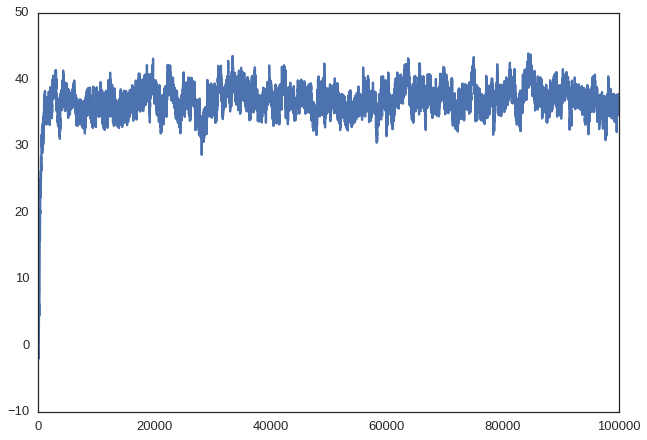

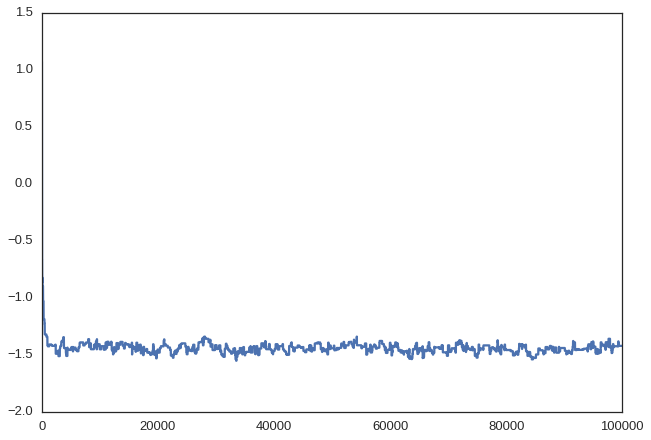

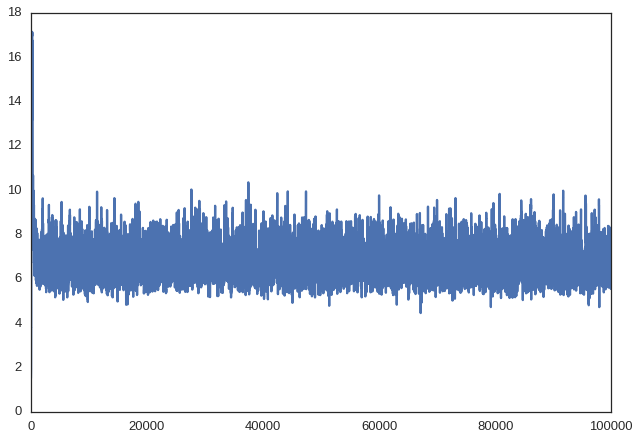

In [43]:
dump_mcmc_chain(chain)    

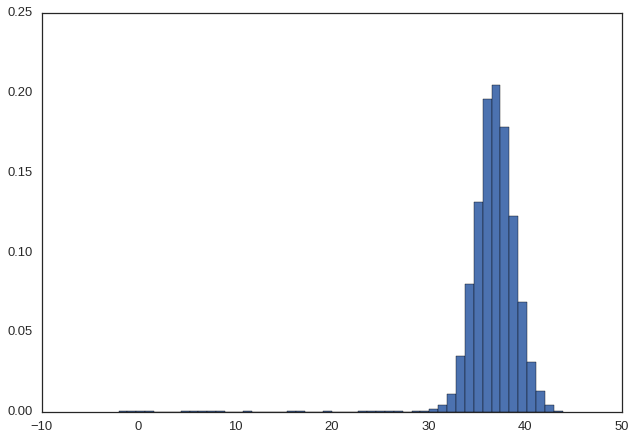

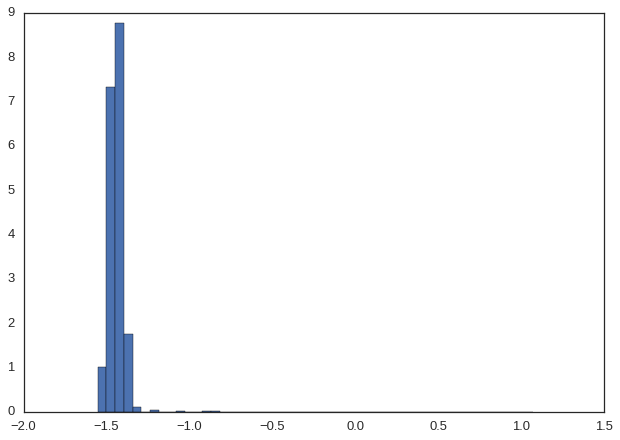

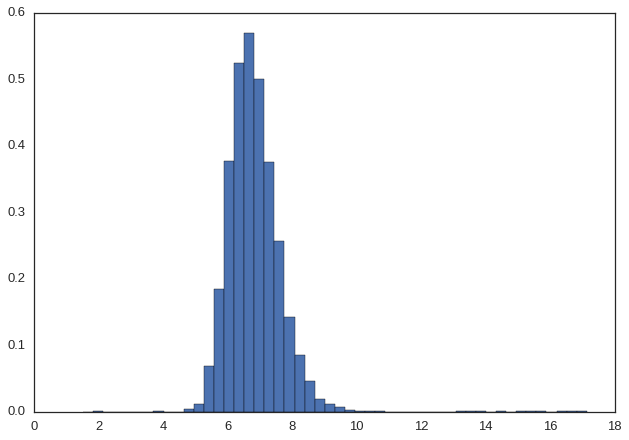

In [44]:
dump_mcmc_density(chain)

In [45]:
theta_pred = chain.mean(axis=0)
print theta_pred
print line_log_posterior(theta_pred, data)

[ 36.79802752  -1.44132449   6.82521719]
-121.596457126


In [46]:
theta_pred2 = chain[1000:].mean(axis=0)
print theta_pred2
print line_log_posterior(theta_pred2, data)

[ 36.93669369  -1.44412796   6.80337155]
-121.571708207


In [47]:
print theta_true
print line_log_posterior(theta_true, data)

(40, -1.5, 4)
-141.641786269


In [63]:
# Create some convenience routines for plotting
def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


def plot_MCMC_trace(ax, chain):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(chain[:,0], chain[:,1])
    ax.contour(xbins, ybins, sigma.T)
    ax.plot(chain[:,0], chain[:,1], ',k', alpha=0.1)
    ax.set_xlabel("c")
    ax.set_ylabel("m")    

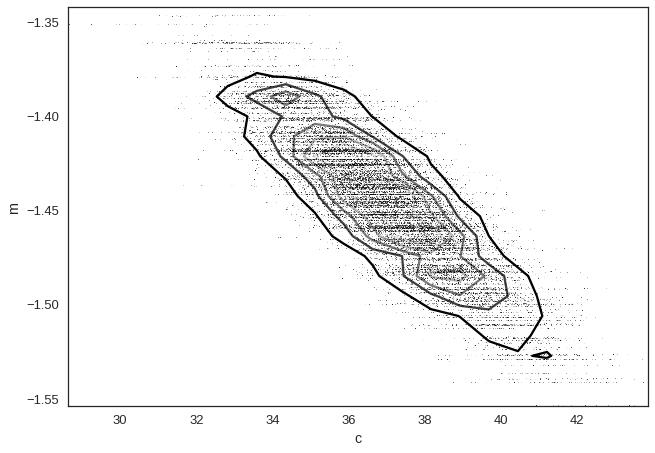

In [64]:
fig, ax = plt.subplots()
plot_MCMC_trace(ax,chain[1000:])

In [61]:
def plot_MCMC_model(ax, data, chain):
    """Plot the linear model and 2sigma contours"""

    c, m, s = chain[:,0], chain[:,1], chain[:,2]
    #c, m, s = chain.mean(axis=0)
    x = np.linspace(-20, 120, 10)
    y = c.reshape(c.shape[0],1) + np.matmul(m.reshape(m.shape[0],1),x.reshape(1,x.shape[0]))

    meanline = y.mean(0)
    sig = 2 * y.std(0)

    err = 2 * s.mean()
    ax.errorbar(data[:,0], data[:,1], yerr=err, fmt='ok',  ecolor='gray')
    #ax.plot(data[:,0], data[:,1], 'ok')
    
    ax.plot(x, meanline, '-k')
    ax.fill_between(x, meanline - sig, meanline + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')

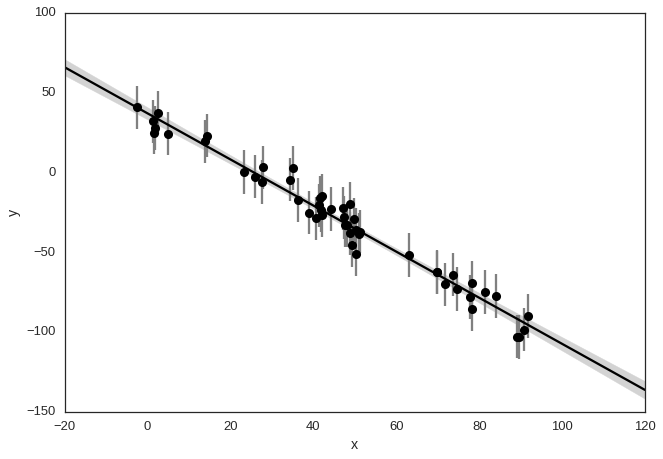

In [62]:
fig, ax = plt.subplots()
plot_MCMC_model(ax, data,chain[1000:])    

In [50]:
#########################################################
########### reformulate for a Neural Network ############
#########################################################

In [52]:
# hold on to your panties...

The objective is to fit a set of points $(x_i0, x_i1, y_i)$ with a forward feeding model(with some white noise) the model is:

\begin{equation} 
 h_0     := 1                                    \\
 h_1     := sigmoid(\sum_i(\alpha_i * x_i))      \\
 h_2     := sigmoid(\sum_i(\beta_i  * x_i))      \\
 o       := sigmoid(\sum_i(\gamma_i * h_i))      \\
 \hat{y} := o + \epsilon                         \\
 \epsilon :\sim \text{Normal}(0, \frac{1}{\delta^2})   
\end{equation}

Note: This is assuming the $x_0$ is constant 1. 

As with the line regression we assume the fit is perfect but there is some error term $\epsilon$ for any nosie in the sampled values... once again solve for the error:

\begin{equation} 
 \epsilon = y_i - \hat{y}(x|\theta)   \\ 
\end{equation}

SO again we are back at the same formulation as the linear regression.. 

\begin{equation} 
 \epsilon :\sim \text{Normal}(0, \frac{1}{\delta})   \\
 P(\epsilon|\theta) = \frac{\sqrt{\delta}}{{\sqrt{2\pi}}} \exp\left[-\frac{\delta\epsilon^2}{2}\right]  \\
 P(x_i,y_i|\theta) = \frac{\sqrt{\delta}}{{\sqrt{2\pi}}} \exp\left[-\frac{\delta(y_i - o_i)^2}{2}\right]
\end{equation}

Them proceed with the mutually exclusive assumption and compute  $P(y,x|\theta)$ the "likelyhood" as follows:

\begin{align}
P(x,y|\theta) = \prod_i P(x_i,y_i|\theta)
\end{align}

Again we target the $max(P(\theta|y,x))$ and to do so via MCMC we  formulate something that works like the "posterior" $P(\theta|y,x)$: 

Since we have $P(x,y|\theta)$ We can now transform it using Bayes theorm:

\begin{align} 
P(\theta|x,y) \propto P(x,y|\theta) P(\theta)   
\end{align}

So back to the problem of "priors" $P(\theta)$... we know that slopes should operate on angles.. the problem is these ones are behind a nonlinear function.. that puts a spanner in the works. we will shift to precision over the std deviation

In [53]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [54]:
# generate the input data
r = np.arange(-2,3)
xx,yy = np.meshgrid(r,r)
xx = xx.flatten()
yy = yy.flatten()

xx   = xx.reshape(xx.shape[0],1)
yy   = yy.reshape(yy.shape[0],1)
ones = np.ones((yy.shape[0],1))

x = np.concatenate((ones,xx,yy), axis=1)

In [55]:
# Start with a trival model
def the_truth_v1(x):
    a = x[:,1] + x[:,2] >  1
    return (a * 1.0).reshape(a.shape[0],1)

def model_v1(theta,x):
    # convert angles to slopes
    weights = np.tan(theta[1:])
    o = sigmoid(np.sum( weights[0:3] * x, axis=1))
    return o.reshape(o.shape[0],1)

In [56]:
#take a peek at what this will look like
y = the_truth_v1(x)
y.reshape(r.shape[0],r.shape[0])

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  1.],
       [ 0.,  0.,  1.,  1.,  1.]])

In [57]:
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)

In [58]:
#take a guess at what the real model will fit to..
true_theta = [1.0,2.0,1.0,1.0]
y_true = model_v1(true_theta, x)
y_true_clip = (y_true > 0.5) * 1.0

with printoptions(formatter={'float': lambda x: '%0.3f' % (x)}):
    print y_true.reshape(r.shape[0],r.shape[0])
print y_true_clip.reshape(r.shape[0],r.shape[0])

[[0.000 0.001 0.005 0.023 0.101]
 [0.001 0.005 0.023 0.101 0.348]
 [0.005 0.023 0.101 0.348 0.717]
 [0.023 0.101 0.348 0.717 0.923]
 [0.101 0.348 0.717 0.923 0.983]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  1.]
 [ 0.  0.  1.  1.  1.]]


In [59]:
 def precept_log_likelihood(theta,x,y, model):
    # the guassains precesion is out of range (-ve)
    if theta[0] <= 0:
        return -np.inf # log(0)
    
    # the slope angles are out of range (-pi/2 < x < pi\/2)
    if np.sum(theta[1:9] >  np.pi).sum() > 0:
        return -np.inf # log(0)
    
    o = model(theta,x) 

    err = y - o
    
    err = np.sum(err**2)    
    err =  err * theta[0] / 2
    sigma = x.shape[0] * np.log(np.sqrt(theta[0]))
    res = sigma - err  
    return res

def precept_log_posterior(theta,x,y, model):
    return precept_log_likelihood(theta,x,y, model)

In [60]:
precept_log_posterior(np.ones(4),
                      x[:2,:],y[:2],
                      lambda t,x: model_v1(t,x))

-0.0009460541322121234

In [61]:
# create an limiter (to fit angles that get out of bounds)
def rerange(x, limit):
    c = np.floor(x / limit)
    r = x - (c * limit)
    e = r < 0
    e = e * limit
    return r + e

In [65]:
def precept_clean(theta):
    if theta[0] < 0:
        theta[0] = -theta[0]
    theta[1:] = rerange(theta[1:], np.pi)
    return theta
    
def precept_proposal(theta):
    # single item udpate
    idx = np.random.randint(theta.shape[0])
    ntheta = theta.copy()
    ntheta[idx] = theta[idx] + 0.3*np.random.randn()
    return precept_clean(ntheta)

In [66]:
# test system
log_sampler(samples  = 5, 
            init     = precept_proposal(np.random.randn(4)),
            proposer = lambda t: precept_proposal(t),
            weighter = lambda t: precept_log_posterior(t,x,y,
                                                       lambda t,x: model_v1(t,x)),
            debug= True)

curr: ( 2.20584645561 ) [ 1.81651953  1.79257827  2.71656778  0.59467483]
prop: ( 2.1667342354 ) [ 1.81651953  1.79257827  2.59150009  0.59467483]
acc:  ( -0.0391122202113 ) True
accepting..
curr: ( 2.1667342354 ) [ 1.81651953  1.79257827  2.59150009  0.59467483]
prop: ( 2.4496934104 ) [ 1.81651953  1.79257827  0.2264417   0.59467483]
acc:  ( 0.282959175 ) True
accepting..
curr: ( 2.4496934104 ) [ 1.81651953  1.79257827  0.2264417   0.59467483]
prop: ( 2.57053329016 ) [ 1.81651953  1.79257827  0.40103257  0.59467483]
acc:  ( 0.120839879762 ) True
accepting..
curr: ( 2.57053329016 ) [ 1.81651953  1.79257827  0.40103257  0.59467483]
prop: ( 2.3978357361 ) [ 1.81651953  1.79257827  0.40103257  0.38762297]
acc:  ( -0.172697554064 ) True
accepting..


array([[ 1.81651953,  1.79257827,  2.71656778,  0.59467483],
       [ 1.81651953,  1.79257827,  2.59150009,  0.59467483],
       [ 1.81651953,  1.79257827,  0.2264417 ,  0.59467483],
       [ 1.81651953,  1.79257827,  0.40103257,  0.59467483],
       [ 1.81651953,  1.79257827,  0.40103257,  0.38762297]])

In [67]:
# do the real run
chain_v1 = log_sampler(samples  = 100000, 
                       init     = precept_proposal(np.random.randn(4)),
                       proposer = lambda t: precept_proposal(t),
                       weighter = lambda t: precept_log_likelihood(t,x,y,
                                                                   lambda t,x: model_v1(t,x)))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [68]:
chain_v1.shape

(100000, 4)

In [69]:
theta_mcmc_v1 = chain_v1.mean(axis=0)
print theta_mcmc_v1

[ 105.04081415    1.64890005    1.45518318    1.45476007]


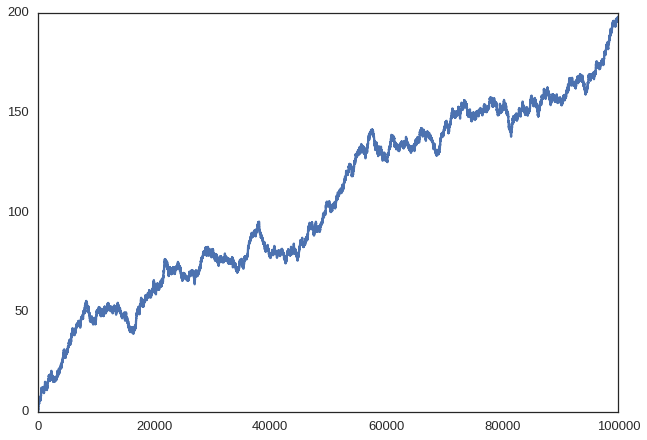

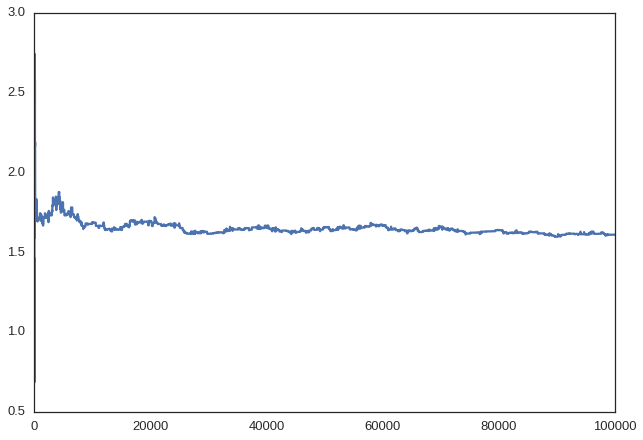

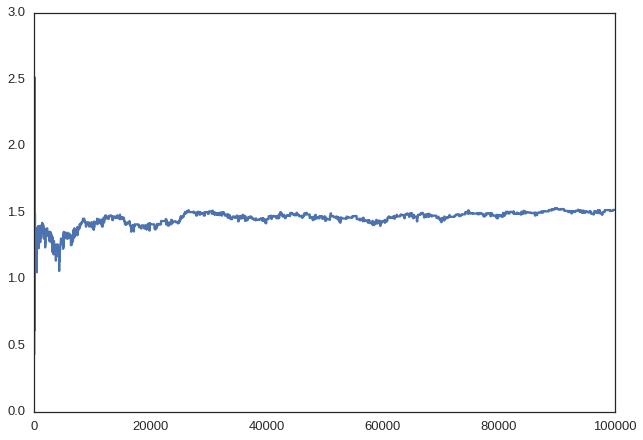

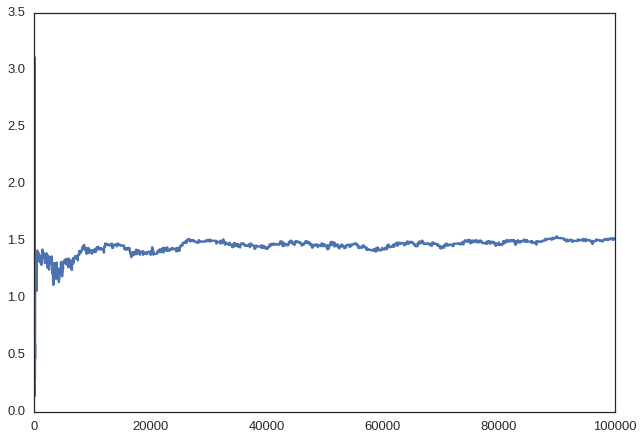

In [70]:
dump_mcmc_chain(chain_v1)

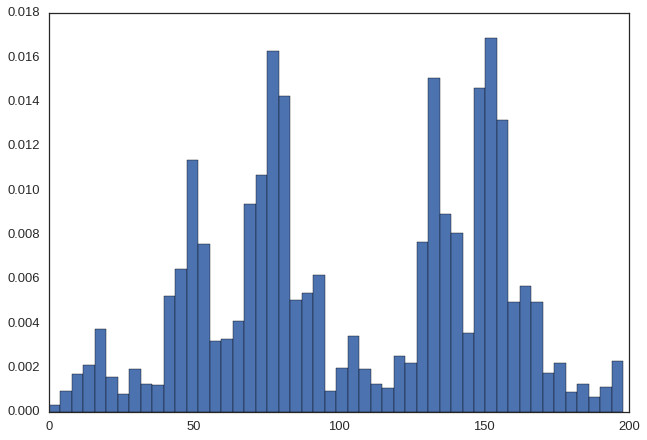

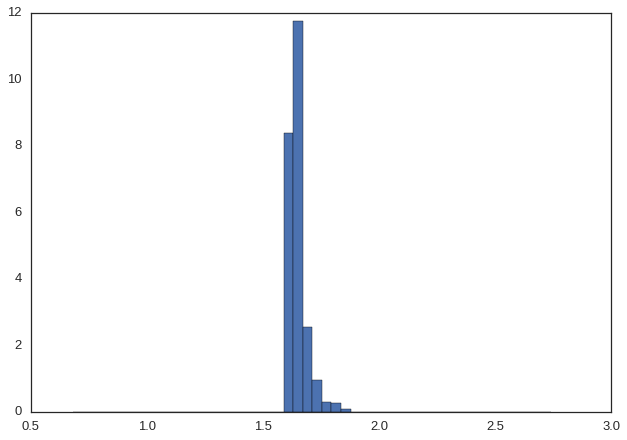

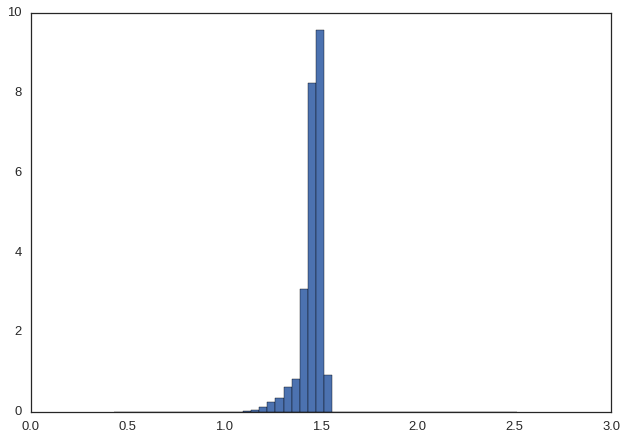

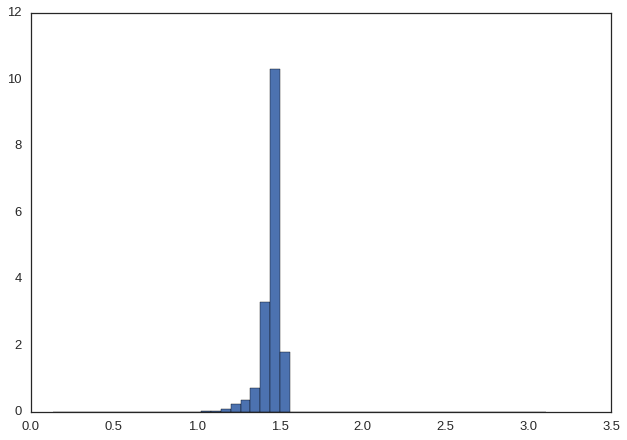

In [71]:
dump_mcmc_density(chain_v1)

In [72]:
y_mcmc_v1 = model_v1(theta_mcmc_v1, x)
y_mcmc_v1_clip =(y_mcmc_v1 > 0.5) * 1.0

print y_mcmc_v1.reshape(r.shape[0],r.shape[0])
print y_mcmc_v1_clip.reshape(r.shape[0],r.shape[0])

[[  3.30803844e-21   1.81662060e-17   9.97603400e-14   5.47837311e-10
    3.00845824e-06]
 [  1.75997088e-17   9.66494015e-14   5.30753486e-10   2.91464238e-06
    1.57537517e-02]
 [  9.36354748e-14   5.14202405e-10   2.82375208e-06   1.52699864e-02
    9.88393145e-01]
 [  4.98167454e-10   2.73569609e-06   1.48008532e-02   9.88024019e-01
    9.99997793e-01]
 [  2.65038604e-06   1.43459230e-02   9.87643301e-01   9.99997722e-01
    1.00000000e+00]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  1.]
 [ 0.  0.  1.  1.  1.]]


In [73]:
def the_truth_v2(x):
    a = x[:,1] + x[:,2] >  1
    b = x[:,1] + x[:,2] < -1
    c = np.logical_or(a, b)
    c = c.reshape(c.shape[0], 1) 
    return (c * 1.0)

    
def model_v2(theta,x):
    # convert angles to slopes
    weights = np.tan(theta[1:])
    
    h      = np.ones((x.shape[0], 3))
    h[:,1] = sigmoid(np.sum( weights[0:3] * x, axis=1))
    h[:,2] = sigmoid(np.sum( weights[3:6] * x, axis=1))

    h = h * weights[6:9]
    
    o = sigmoid(np.sum(h, axis=1))
    o = o.reshape(o.shape[0],1)
    return o;

In [74]:
y_v2 = the_truth_v2(x)
y_v2.reshape(r.shape[0],r.shape[0])

array([[ 1.,  1.,  1.,  0.,  0.],
       [ 1.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  1.],
       [ 0.,  0.,  1.,  1.,  1.]])

In [75]:
v = -1 + 2*np.pi
print v, np.tan(v), np.tan(np.pi/4)
print np.arctan(2)

5.28318530718 -1.55740772465 1.0
1.10714871779


In [76]:
#take a guess at what the real model will fit to..
true_theta_v2 = np.array([1.0,2.0,1.0,1.0,2.0,-1.0,-1.0,-0.5,np.pi/4,np.pi/4])
true_theta_v2 = precept_clean(true_theta_v2)
print true_theta_v2

y_true_v2 = model_v2(true_theta_v2, x).reshape(r.shape[0],r.shape[0])
y_true_v2_clip = (y_true_v2 > 0.5) * 1.0

with printoptions(formatter={'float': lambda x: '%0.3f' % (x)}):
    print y_true_v2
print y_true_v2_clip.reshape(r.shape[0],r.shape[0])



[ 1.          2.          1.          1.          2.          2.14159265
  2.14159265  2.64159265  0.78539816  0.78539816]
[[0.607 0.593 0.544 0.456 0.415]
 [0.593 0.544 0.456 0.415 0.456]
 [0.544 0.456 0.415 0.456 0.544]
 [0.456 0.415 0.456 0.544 0.593]
 [0.415 0.456 0.544 0.593 0.607]]
[[ 1.  1.  1.  0.  0.]
 [ 1.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  1.]
 [ 0.  0.  1.  1.  1.]]


In [77]:
log_sampler(samples  = 10, 
            #init     = precept_proposal(np.random.randn(10)),
            init     = precept_clean(true_theta_v2),
            proposer = lambda t: precept_proposal(t),
            weighter = lambda t: precept_log_likelihood(t,x,y,
                                                        lambda t,x: model_v2(t,x)),
           debug=True)

curr: ( -2.79789367542 ) [ 1.          2.          1.          1.          2.          2.14159265
  2.14159265  2.64159265  0.78539816  0.78539816]
prop: ( -2.94875409548 ) [ 0.98460502  2.          1.          1.          2.          2.14159265
  2.14159265  2.64159265  0.78539816  0.78539816]
acc:  ( -0.150860420058 ) True
accepting..
curr: ( -2.94875409548 ) [ 0.98460502  2.          1.          1.          2.          2.14159265
  2.14159265  2.64159265  0.78539816  0.78539816]
prop: ( -3.12774477172 ) [ 0.98460502  2.          1.          0.51917608  2.          2.14159265
  2.14159265  2.64159265  0.78539816  0.78539816]
acc:  ( -0.178990676238 ) True
accepting..
curr: ( -3.12774477172 ) [ 0.98460502  2.          1.          0.51917608  2.          2.14159265
  2.14159265  2.64159265  0.78539816  0.78539816]
prop: ( -3.08549416905 ) [ 0.98460502  2.          1.          0.51917608  2.          2.14159265
  2.14159265  2.64159265  0.94381448  0.78539816]
acc:  ( 0.0422506026701 ) 

array([[ 1.        ,  2.        ,  1.        ,  1.        ,  2.        ,
         2.14159265,  2.14159265,  2.64159265,  0.78539816,  0.78539816],
       [ 0.98460502,  2.        ,  1.        ,  1.        ,  2.        ,
         2.14159265,  2.14159265,  2.64159265,  0.78539816,  0.78539816],
       [ 0.98460502,  2.        ,  1.        ,  0.51917608,  2.        ,
         2.14159265,  2.14159265,  2.64159265,  0.78539816,  0.78539816],
       [ 0.98460502,  2.        ,  1.        ,  0.51917608,  2.        ,
         2.14159265,  2.14159265,  2.64159265,  0.94381448,  0.78539816],
       [ 0.98460502,  2.        ,  1.        ,  0.51917608,  2.        ,
         2.14159265,  2.14159265,  2.64159265,  0.94381448,  0.78539816],
       [ 0.98460502,  1.94852959,  1.        ,  0.51917608,  2.        ,
         2.14159265,  2.14159265,  2.64159265,  0.94381448,  0.78539816],
       [ 0.98460502,  1.94852959,  1.        ,  0.06460582,  2.        ,
         2.14159265,  2.14159265,  2.64159265

In [78]:
chain_v2 = log_sampler(samples  = 100000, 
                      #init     = precept_proposal(np.random.randn(10)),
                       init     = precept_clean(true_theta_v2),
                       proposer = lambda t: precept_proposal(t),
                       weighter = lambda t: precept_log_likelihood(t,x,y,
                                                                   lambda t,x: model_v2(t,x)))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [79]:
chain_v2

array([[  1.        ,   2.        ,   1.        , ...,   2.64159265,
          0.78539816,   0.78539816],
       [  1.        ,   2.        ,   1.        , ...,   2.72913797,
          0.78539816,   0.78539816],
       [  1.        ,   2.        ,   1.        , ...,   2.72913797,
          0.78539816,   0.78539816],
       ..., 
       [ 95.89696145,   1.12263812,   0.67791433, ...,   1.45180192,
          1.02560344,   1.5917775 ],
       [ 95.89696145,   1.06075741,   0.67791433, ...,   1.45180192,
          1.02560344,   1.5917775 ],
       [ 95.89696145,   1.36937023,   0.67791433, ...,   1.45180192,
          1.02560344,   1.5917775 ]])

In [80]:
theta_mcmc_v2 = chain_v2.mean(axis=0)
print theta_mcmc_v2

[ 55.18409596   1.52288939   1.42178955   1.45043983   1.27658153
   2.00253838   2.00633798   1.37783516   1.44009556   1.59660014]


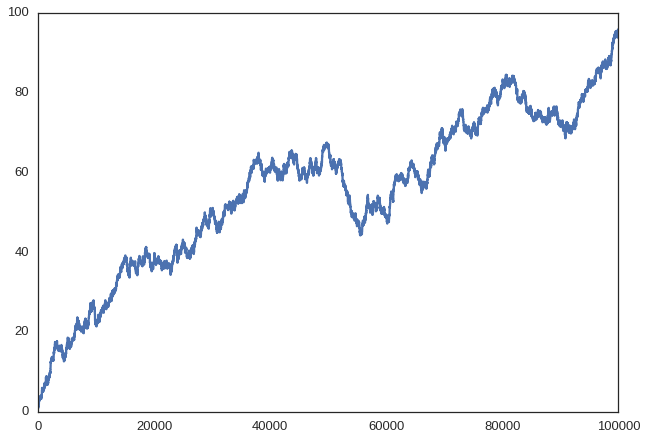

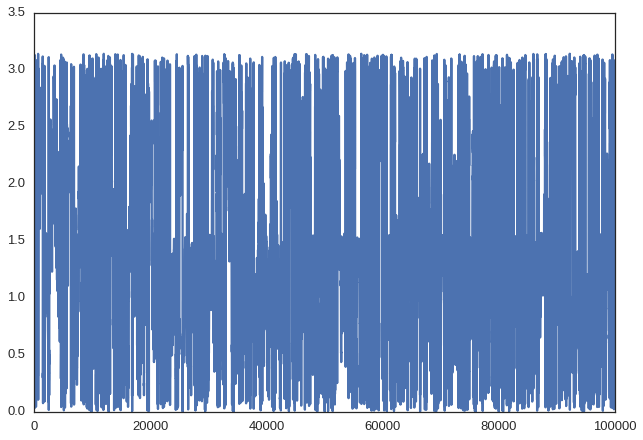

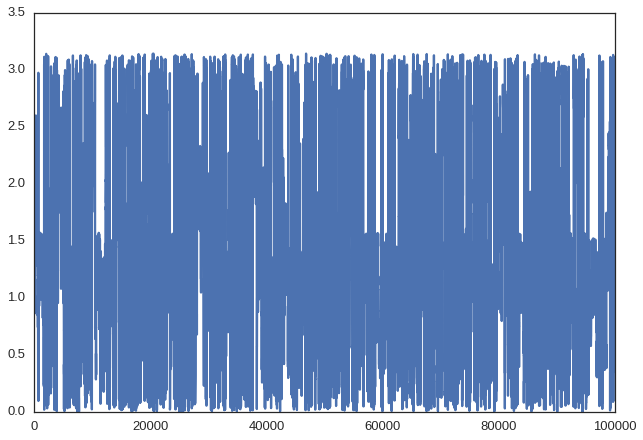

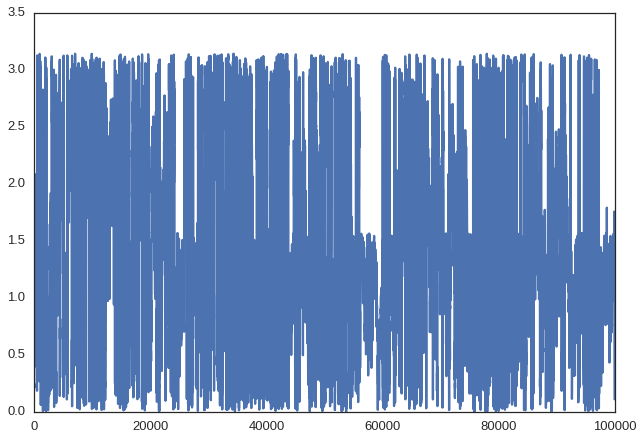

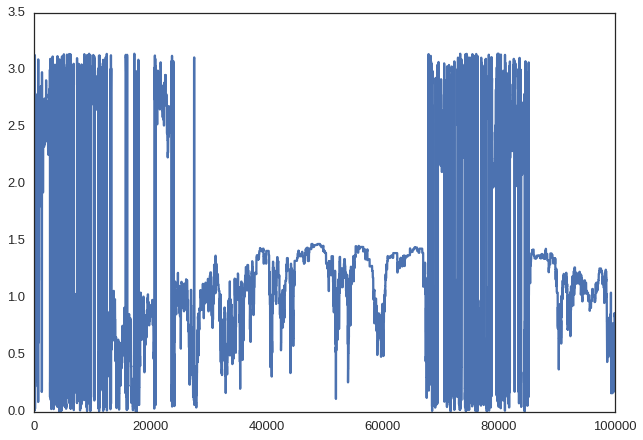

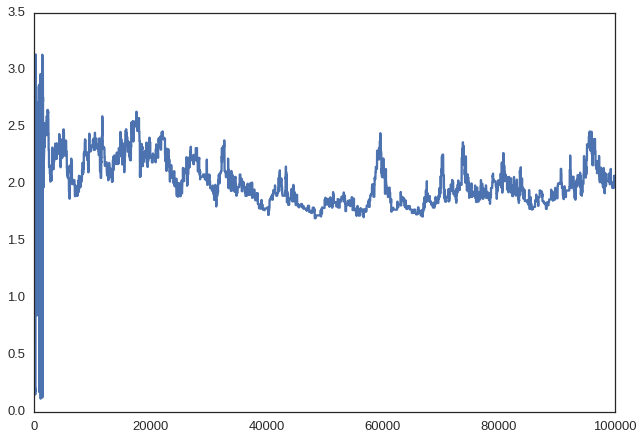

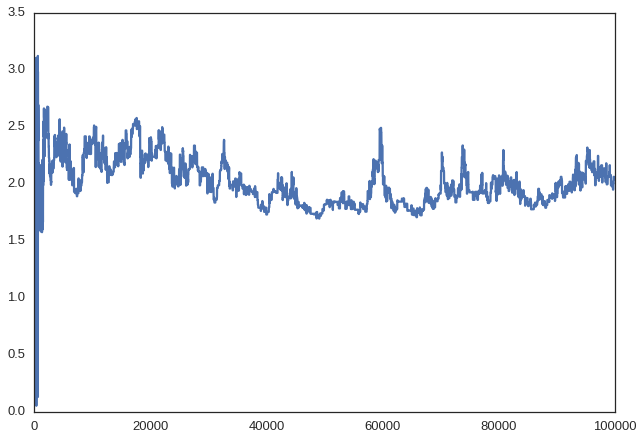

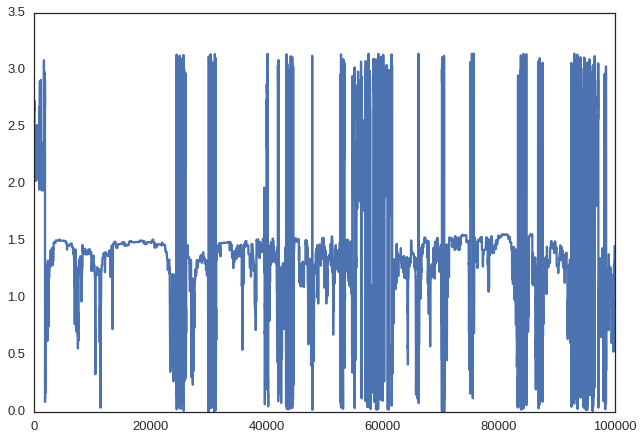

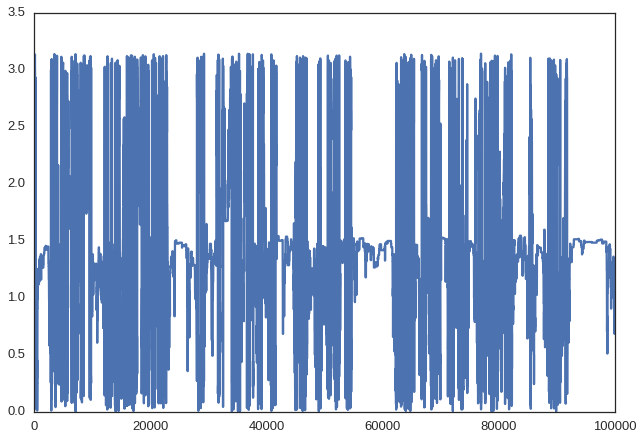

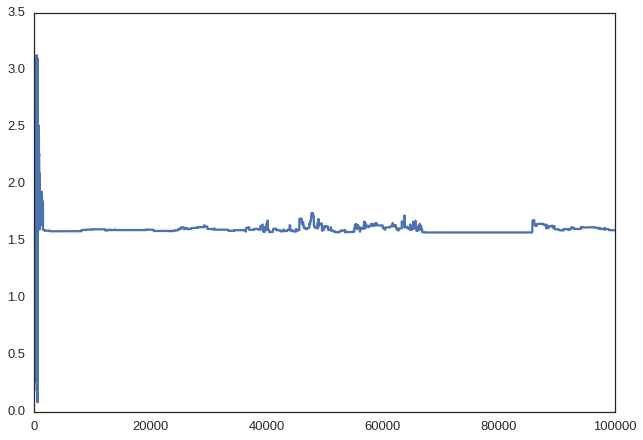

In [81]:
dump_mcmc_chain(chain_v2)

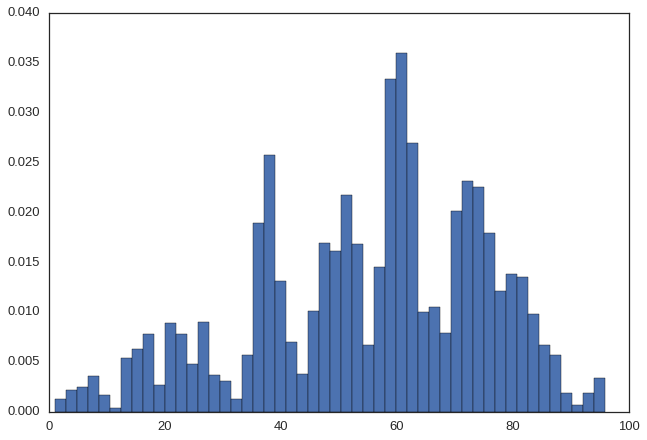

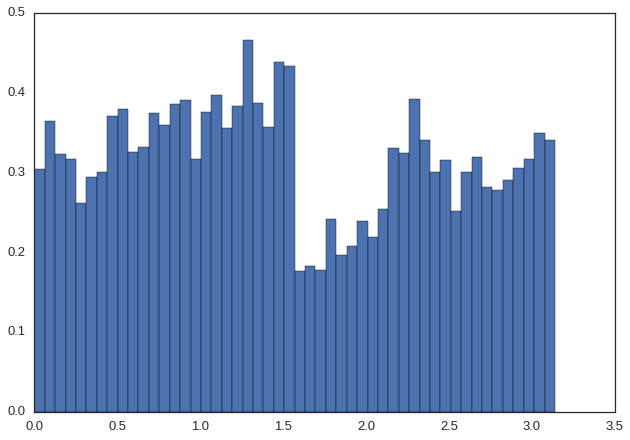

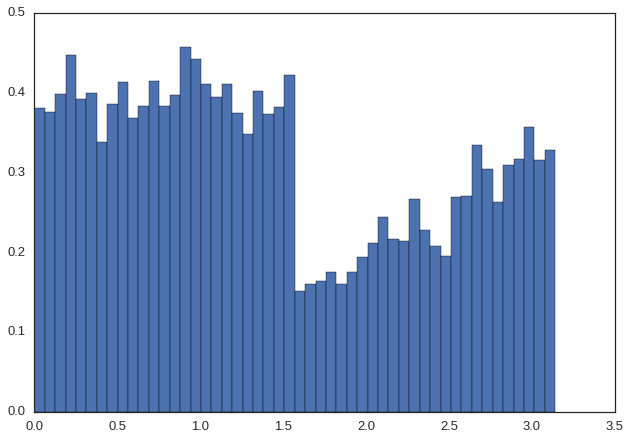

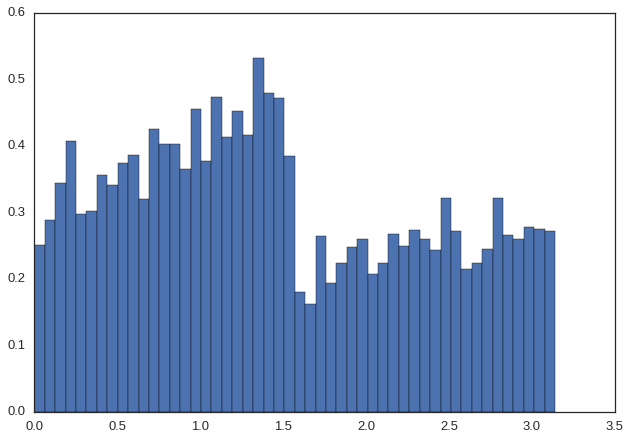

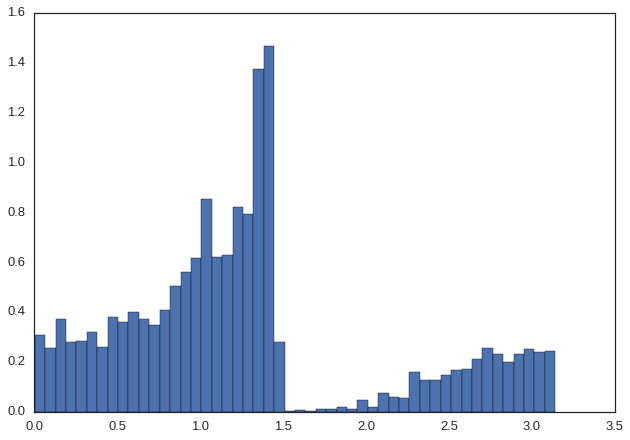

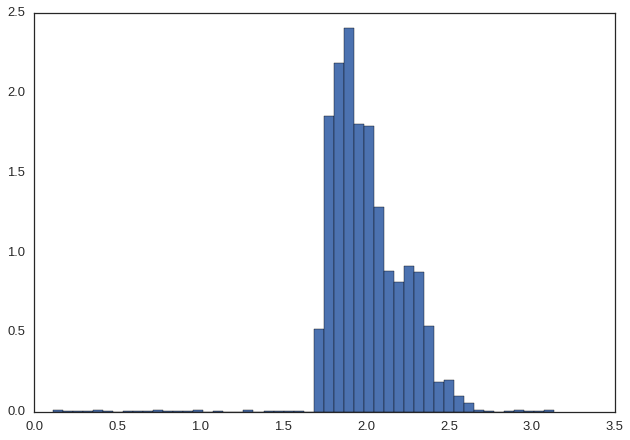

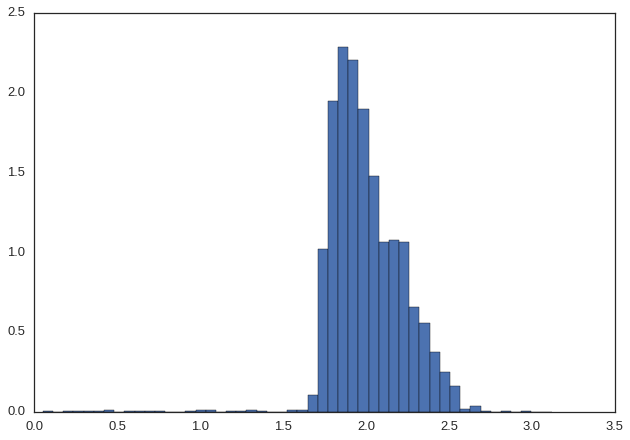

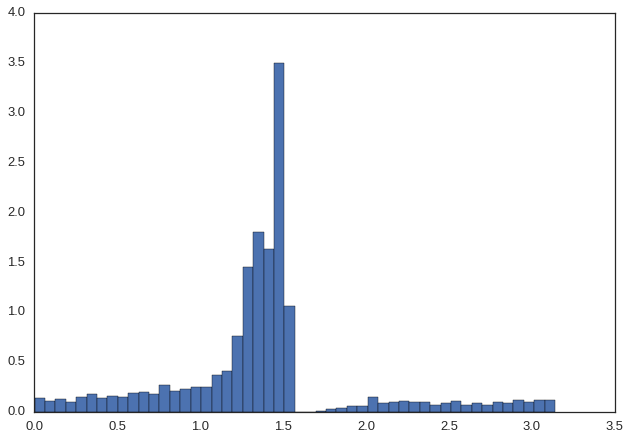

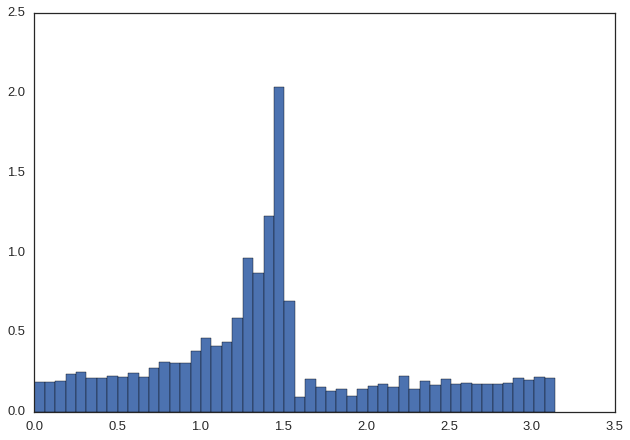

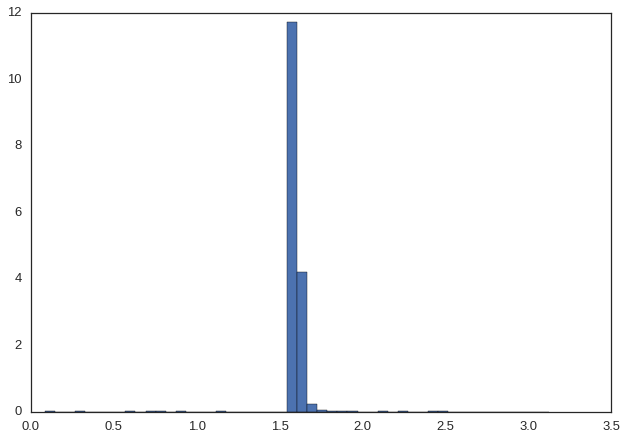

In [82]:
dump_mcmc_density(chain_v2)

In [83]:
y_mcmc_v2 = model_v1(theta_mcmc_v2, x)
y_mcmc_v2_clip =(y_mcmc_v2 > 0.5) * 1.0

print y_mcmc_v2.reshape(r.shape[0],r.shape[0])
print y_mcmc_v2_clip.reshape(r.shape[0],r.shape[0])

[[  1.23163135e-04   8.78225756e-02   9.86885632e-01   9.99982999e-01
    9.99999978e-01]
 [  3.24452359e-01   9.97343211e-01   9.99996592e-01   9.99999996e-01
    1.00000000e+00]
 [  9.99466281e-01   9.99999317e-01   9.99999999e-01   1.00000000e+00
    1.00000000e+00]
 [  9.99999863e-01   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00]]
[[ 0.  0.  1.  1.  1.]
 [ 0.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]
